# Using OBIA for estimating area of Solar Panels in Spain

Using STAC, I am going to download imagery, segment the solar panels and estimate the area they occupy in the fields.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio as rio
import xarray as xr
import rioxarray

import dask.array as da # handle dask arrays
from IPython.display import Image # visualize URLs
import pystac_client # connecting to the STAC API
from rasterio.enums import Resampling # perform re-sampling operations
import shapely # create vector objects
import stackstac # build an on-demand STAC data cube


In [2]:
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)
for collection in client.get_collections():
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [3]:
collection = 'sentinel-2-l2a'

#coordinates 
lat = 37.364
lon = -6.923
point = shapely.Point(lon, lat)
date_range = '2025-04-01/2025-05-16'

In [4]:
search = client.search(
    collections = [collection],
    intersects=point,
    datetime=date_range,
    query = ['eo:cloud_cover<10']
)

items = search.item_collection()
len(items)

2

In [5]:
item_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs = 'EPSG:4326')
item_df 

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:centroid,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,proj:code
0,"POLYGON ((-7.69213 37.94031, -7.87145 37.3139,...",2025-05-15T15:21:11.337Z,sentinel-2b,sentinel-2,[msi],6.094903,"{'lat': 37.42613, 'lon': -7.22372}",29,S,PB,...,S2B_OPER_MSI_L2A_DS_2BPS_20250515T135717_S2025...,0.980395,2025-05-15T11:20:58.831000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/f069...,True,{'sentinel2-to-stac': '2025.03.06'},2025-05-15T15:21:11.337Z,EPSG:32629
1,"POLYGON ((-7.69554 37.94035, -7.87124 37.32824...",2025-04-22T19:32:50.586Z,sentinel-2a,sentinel-2,[msi],4.524603,"{'lat': 37.42651, 'lon': -7.2248}",29,S,PB,...,S2A_OPER_MSI_L2A_DS_2APS_20250422T180305_S2025...,0.992053,2025-04-22T11:21:12.566000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/0950...,True,{'sentinel2-to-stac': '2025.03.06'},2025-04-22T19:32:50.586Z,EPSG:32629


In [6]:
item_df.explore()

In [7]:
ids = item_df.loc[
  (item_df['eo:cloud_cover'] <= 5) &
  (item_df['s2:nodata_pixel_percentage'] <= 10)
]

item = items[ids.index[0]]
item.datetime

datetime.datetime(2025, 4, 22, 11, 21, 12, 566000, tzinfo=tzutc())

In [23]:
aoi = gpd.read_file('solar_aoi.json')
bbox = aoi.total_bounds
aoi.explore()

In [9]:
thumbnail = item.assets["thumbnail"].href
Image(url = thumbnail)

In [26]:
assets = ["red","green","blue","nir","scl"]
cube_all = stackstac.stack(
    item, 
    assets, 
    bounds_latlon = bbox, 
    epsg=32629
    )
scl = cube_all.sel(band=["scl"])
s2_mask = da.isin(scl, [3,8,9])
cube = cube_all.where(~s2_mask)
cube

<xarray.DataArray 'stackstac-d771f9735c44dfdd3d75ae2aaa2a9e74' (time: 1,
                                                                band: 5,
                                                                y: 263, x: 267)> Size: 3MB
dask.array<where, shape=(1, 5, 263, 267), dtype=float64, chunksize=(1, 1, 263, 267), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 8B 2025-04...
    id                                       (time) <U24 96B 'S2A_29SPB_20250...
  * band                                     (band) <U5 100B 'red' ... 'scl'
  * x                                        (x) float64 2kB 6.829e+05 ... 6....
  * y                                        (y) float64 2kB 4.138e+06 ... 4....
    earthsearch:boa_offset_applied           bool 1B True
    ...                                       ...
    raster:bands                             (band) object 40B {'nodata': 0, ...
    title                                    (band) <U30 600B 'Red - 10m' ......
    common_name                              (band) object 40B 'red' ... None
    center_wavelength                        (band) object 40B 0.665 ... None
    full_width_half_max                      (band) object 40B 0.038 ... None
    epsg                                     int64 8B 32629
Attributes:
    spec:           RasterSpec(epsg=32629, bounds=(682890.4628978119, 4135732...
    crs:            epsg:32629
    transform:      | 10.37, 0.00, 682890.46|\n| 0.00,-10.35, 4138455.25|\n| ...
    resolution_xy:  (10.371969363575515, 10.353929459115403)

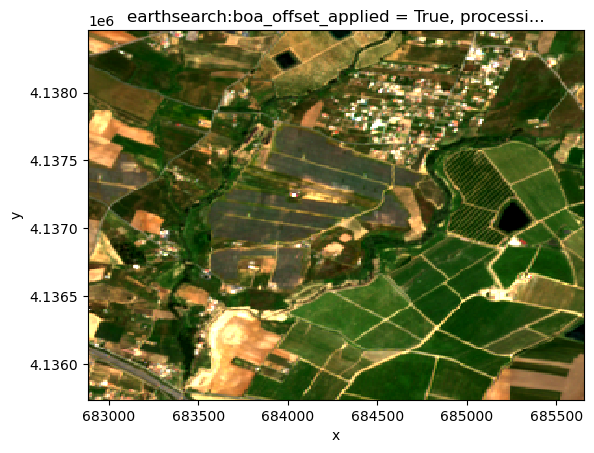

In [27]:
rgb = cube.sel(band=['red', 'green', 'blue']).median("time", keep_attrs=True)
rgb = rgb.compute()
rgb.plot.imshow(
    rgb = 'band',
    robust=True
)